# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [24]:
# Package Imports
import torch
from torch import nn, optim
import torchvision 
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import json
from collections import OrderedDict
import time
import os
import random
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [25]:
#Application parameters:

mean =  [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]
resize = 226
crop = 224
rotation = 30
degrees = 30
batch_size = 64

device = 'gpu'
proc = 1
arch_valid = ['alexanet', 'vgg16', 'resnet18']
arch = 'vgg16'
categories_source = 'cat_to_name.json'
classifier_options = ['min','simple','advanced']
input_size = 0
hidden_leyer = 0
output_size = 0
dropout = 0.5
classifier_option = 'simple'
criterion_option = 1
optimizer_option = 1
learning_rate = 0.006
epochs = 11

filepath_check = 'checkpoint.pth'
filepath_load = ''

# Loading the datasets
dir_data = 'flowers'
dir_train = dir_data + '/train'
dir_valid = dir_data + '/valid'
dir_test = dir_data + '/test'



# Training data augmentation
# Defining transforms for the training, validation, and testing sets

transforms_train = transforms.Compose([transforms.RandomRotation(rotation),
                    transforms.RandomResizedCrop(crop),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean = mean, std = std)])
transforms_train_deep = transforms.Compose([transforms.RandomRotation(rotation),
                    transforms.RandomResizedCrop(crop),
                    transforms.RandomHorizontalFlip(),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
                    transforms.RandomAffine(degrees = degrees, translate=None, scale=(1.1, 2.1), 
                                            shear=16),
                    transforms.ToTensor(),
                    transforms.Normalize(mean = mean, std = std) ])
transforms_valid = transforms.Compose([transforms.Resize(resize),
                    transforms.CenterCrop(crop),
                    transforms.ToTensor(),
                    transforms.Normalize(mean = mean, std = std)])

transforms_test = transforms.Compose( [transforms.Resize(resize),
                    transforms.CenterCrop(crop),
                    transforms.ToTensor(),
                    transforms.Normalize(mean = mean, std = std)] )

data_train = datasets.ImageFolder(dir_train, transform = transforms_train)
data_train_deep = datasets.ImageFolder(dir_train, transform = transforms_train_deep)
data_valid = datasets.ImageFolder(dir_valid, transform = transforms_valid)
data_test  = datasets.ImageFolder(dir_test, transform=transforms_test)


loader_train = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size = batch_size, shuffle=True)
loader_test  = torch.utils.data.DataLoader(data_test , batch_size = batch_size, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [26]:
def get_cat_names(categories_source):
    """Return loaded file and the count of categories in it.
    INPUT:
    Source file path.
    
    OUTPUT: 
    Categories dictionary
    Count of categories."""
    with open(categories_source, 'r') as f:
        cat_to_name = json.load(f)
        l = len(cat_to_name)
        output_size = l
        print(f"There are: {l} categories defined in the '{categories_source}' source file.\nSetting model output_size to {l}.")
        
    return cat_to_name, output_size


def print_cat_names(source):
    """Prints categories from loaded dictionary in a sorted maner.
    
    INPUT:
    Source file path.
    """
    source_sorted = OrderedDict(sorted(cat_to_name.items()))
    print(f"Sorted dictionary items:")
    for key in source_sorted:
        print(f"Key {key:>3} -> {source_sorted[key]}")

In [27]:
#Set up the categories dictionary and set nn model output size to match
cat_to_name, output_size = get_cat_names(categories_source)
# print_cat_names(cat_to_name)

There are: 102 categories defined in the 'cat_to_name.json' source file.
Setting model output_size to 102.


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [28]:
def set_device(proc):
    """Sets device switch for cuda.
    INPUT:
    GPU setting
    """
    
    if proc and torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Good, GPU is available for data processing.")
    elif proc == 0 and torch.cuda.is_available():
        device = torch.device('cpu')
        proc = 0
        print(f"Cuda is available but you choose to run on CPU. It's maddness LOL :)")
    else:
        device = torch.device('cpu')
        proc = 0
        print(f"Cuda unavailable, will run on CPU. It'll take a lot of time... ¯\_(ツ)_/¯")
    print("But, where is DOJO? XD")
    return device

In [29]:
#Set the device for informational use only 
device = set_device(proc)

Good, GPU is available for data processing.
But, where is DOJO? XD


In [30]:
def load_model(model_arch):
    """Load a pretrained nn model.
    Return nn model and its input size. Print processing info.
    INPUT:
    NN architecture type switch
    
    OUTPUT: 
    NN model and approprieate input size"""
    ma = model_arch.lower()
    if ma == 'alexnet':
        model = models.alexnet(pretrained=True) 
        input_size = model.classifier[1].in_features
    elif ma == 'vgg16':
        model = models.vgg16(pretrained=True)
        input_size = model.classifier[0].in_features
    elif ma == 'resnet18':
        model = models.resnet18(pretrained=True)
        input_size = model.fc.in_features
    else:
        print(f"Warning - unknown model architecture type!\nPlease choose from available model architectures: {arch_valid}.")
        return
    
    # Prevent model from training parameters
    for param in model.parameters():
        param.requires_grad = False
        
    print(f"Succesfully loaded pretrained {ma} model with {input_size} input features.")

    return model, input_size

In [31]:
#Set the model and input size
model,input_size = load_model('vgg16')

Succesfully loaded pretrained vgg16 model with 25088 input features.


In [32]:
#Inspect model classifier ( resnet model use .fc instead)
model.classifier 

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [37]:
#Set hidden leyer, here 
hidden_leyer = 4096

In [38]:
def set_classifier(model, classifier_option, input_size, output_size, dropout, hidden_leyer, criterion_option, optimizer_option):
    """Return nn model classifier type, optimiser and criterion. Prints processing info.
    INPUT:
    NN model: model, classifier switch: str, input size: int, output size: int, hidden leyer: int, criterion switch: int[0,1], optimiser switch: int[0,1]  
    
    OUTPUT: 
    Updated model, optimizer and  criterion"""
    if hidden_leyer < output_size: 
        print(f"Hidden leyer size is to small, setting hidden_leyer to {output_size*2}!")
        hidden_leyer = output_size*2
        
    co = classifier_option.lower()
    print(f"Setting classifier to: {co}")
    
    print(f"Choosen criterion option: {criterion_option}")
    print(f"Choosen optimizer option: {optimizer_option}") 
    
    if co == 'advanced':
        c_type = OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_leyer)),
        ('dropout1', nn.Dropout(dropout)),
        ('relu1', nn.ReLU()),
        ('fc2', nn.Linear(hidden_leyer, output_size*2)),
        ('dropout2', nn.Dropout(dropout/2)),
        ('output', nn.Linear(output_size*2, output_size)),
        ('softmax', nn.LogSoftmax(dim = 1))])
        
    elif co == 'simple':
        c_type = OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_leyer)),
        ('dropout', nn.Dropout(dropout)),
        ('relu1', nn.ReLU()),
        ('output', nn.Linear(hidden_leyer, output_size)),
        ('softmax', nn.LogSoftmax(dim = 1))])
    
    elif co == 'min':
        c_type = OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_leyer)),
        ('dropout', nn.Dropout(dropout)),
        ('output', nn.Linear(hidden_leyer, output_size)),
        ('softmax', nn.LogSoftmax(dim = 1))])
    else:
        print(f"Warning - unknown model architecture type!\nPlease choose from available model architectures: {arch_valid}.")
        return
    
    # Update model classifier with the new one
    if (type(model.classifier) != 'undefined'):
        model.classifier = nn.Sequential(c_type)
    elif (type(model.fc) != 'undefined'):
        model.fc = nn.Sequential(c_type) 
        #to do - update it with the cli version so resnet .fc works properly
    else:
        print("Wooops, can't set such classifier!")
        return
    
    # Set the error function
    if criterion_option == 0:
        criterion_new = nn.NLLLoss()
    elif criterion_option == 1:
         criterion_new = nn.CrossEntropyLoss()
    else:
        print("Wrong criterion switch!")
        return
    
    # Set the optimizer function       
    if optimizer_option == 0:
        optimizer_new = optim.Adam(model.classifier.parameters(), lr = learning_rate)
    elif optimizer_option == 1:
         optimizer_new = optim.SGD(model.classifier.parameters(), lr = learning_rate)
    else:
        print("Wrong optimizer switch!")
        return  

    print(f"Criterion:{criterion_new}\nOptimizer: {optimizer_new}")
    return model, optimizer_new, criterion_new

In [39]:
# Set updated model 
model, optimizer, criterion = set_classifier(model,classifier_option,input_size, output_size, dropout, hidden_leyer, criterion_option, optimizer_option)

Setting classifier to: simple
Choosen criterion option: 1
Choosen optimizer option: 1
Criterion:CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.006
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [40]:
#Inspect model classifier 
model.classifier 

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (dropout): Dropout(p=0.5)
  (relu1): ReLU()
  (output): Linear(in_features=4096, out_features=102, bias=True)
  (softmax): LogSoftmax()
)

In [42]:
def train_model(model, loader_train, criterion, optimizer, epochs, proc):
    """Train nn model on a new data and performs validation pass every epoch.
    INPUT:
    NN model: model, loader: test data loader, criterion switch: int[0,1], optimiser switch: int[0,1],
    epochs: int - number of training cycles, gpu switch: int[0,1]
    
    OUTPUT:
    Updated trained model"""
    if proc and torch.cuda.is_available():  
        device = torch.device('cuda')
        print("Starting model training session with cuda (gpu).")
        model.to(device)

    else:
        print("Starting model training session with cpu.")
        device = torch.device('cpu')

    start = time.time()
    steps = 0
    print_every = output_size
    
    for epoch in range(epochs):
        running_loss = 0
            
        for images, labels in loader_train:
            steps += 1

            images, labels = images.to(device), labels.to(device)
            
            # Reset optimizer gradients
            optimizer.zero_grad()
            
            # Get output probabilities
            outputps = model(images)
            
            # Get loss values
            loss = criterion(outputps, labels)
            
            # Backpropagate 
            loss.backward()
            
            # Update parameter based on optimiser gradients
            optimizer.step()
            
            # Sum the loss
            running_loss += loss.item()
            
            # Start evaluation in a conditional period 
            if steps % print_every == 0: 

                val_loss = 0
                accuracy = 0
                # Disabling gradients calculations
                with torch.no_grad(): 
                    model.eval() # Disable dropout
                    for images_v, labels_v in loader_valid:
                        images_v, labels_v = images_v.to(device), labels_v.to(device)
                        
                        # Get the eval probabilities 
                        outputps_v = model(images_v)
                        
                        # Get the loss
                        loss_v = criterion(outputps_v, labels_v)
                        
                        # Add loss to the validation set's running loss
                        val_loss += loss_v.item()
                        
                        # Transform probabilities      
                        ps = torch.exp(outputps_v)
                        
                        # Gat the top categories based on probabilities 
                        top_ps, top_class = ps.topk(1, dim=1)
                        
                        # Get the ammount of corectly predicted categories
                        equality = top_class == labels_v.view(*top_class.shape)
                
                        # Sum the mean of eval pass accuracy 
                        accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                        
                print(f"Epoch { (epoch+1):>3d}/{epochs} "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {val_loss/len(loader_valid):.3f}.. "
                  f"Test accuracy: {accuracy/len(loader_valid):.3f}..")  
            
            model.train()
            
    print(f"Processing time: {((time.time() - start)//60):.0f}min {((time.time() - start) % 60):.0f}sec")

In [43]:
#Start trining 
train_model(model, loader_train, criterion, optimizer, epochs, proc)

Starting model training session with cuda (gpu).
Epoch   1/11 Train loss: 4.051.. Valid loss: 3.119.. Test accuracy: 0.353..
Epoch   2/11 Train loss: 2.939.. Valid loss: 2.014.. Test accuracy: 0.600..
Epoch   3/11 Train loss: 2.141.. Valid loss: 1.395.. Test accuracy: 0.738..
Epoch   4/11 Train loss: 1.702.. Valid loss: 1.046.. Test accuracy: 0.804..
Epoch   6/11 Train loss: 1.224.. Valid loss: 0.749.. Test accuracy: 0.854..
Epoch   7/11 Train loss: 1.077.. Valid loss: 0.650.. Test accuracy: 0.883..
Epoch   8/11 Train loss: 0.982.. Valid loss: 0.582.. Test accuracy: 0.874..
Epoch   9/11 Train loss: 0.898.. Valid loss: 0.550.. Test accuracy: 0.887..
Epoch  10/11 Train loss: 0.839.. Valid loss: 0.511.. Test accuracy: 0.889..
Epoch  11/11 Train loss: 0.777.. Valid loss: 0.465.. Test accuracy: 0.903..
Processing time: 27min 51sec


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [44]:
def test_model(model, loader_test, proc):
    """Test nn model on a test data and prints out stats.
    INPUT:
    NN model: model, loader: test data loader, gpu switch  
    """
    if proc and torch.cuda.is_available():  
        device = torch.device('cuda')
        print("Starting model testing session with cuda (gpu).")
        model.to(device)
        
    else:
        print("Starting model testing session with cpu.")
        device = torch.device('cpu')
    
    model.eval()
    start = time.time()

    accuracy = 0
    steps = 0
    with torch.no_grad():
        for images, labels in loader_test:
            steps += 1
            images, labels = images.to(device), labels.to(device)
            test_ps = model(images)

            top_ps, top_class = test_ps.topk(1, dim=1)
            equalities = top_class == labels.view(*top_class.shape)

            accuracy += torch.mean(equalities.type(torch.FloatTensor))
    print(f"Test accuracy: {accuracy/len(loader_test):.6f} processed in: {((time.time() - start)//60):.0f}min {((time.time() - start) % 60):.0f}sec")

In [47]:
# Perform model test
test_model(model,loader_test, proc)

Starting model testing session with cuda (gpu).
Test accuracy: 0.850608 processed in: 0min 17sec


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [49]:
#Inspect the model state
# print("Actual model: \n\n", model, '\n')
# print("The state dict keys: \n\n", model.state_dict().keys())

In [50]:
def checkpoint_save(model, data_source, folder):
    """Passes class data into model and 
    saves the nn state checkpoint to a given folder
    INPUT:
    NN model: model, data source: data loader, filename: save file path string  
    
    OUTPUT:
    Saved file"""
    model.class_to_idx = data_source.class_to_idx

    if (classifier_attribute):
        classifier = model.classifier
    else:
        classifier = model.fc

    checkpoint = {
        'arch': arch,
        'input_size': input_size,
        'output_size': output_size,
        'hidden_leyer': hidden_leyer,
        'epochs': epochs,
        'classifier_option': classifier_option,
        'criterion_option': criterion_option,
        'optimizer_option': optimizer_option,
        'learning_rate': learning_rate,
        'dropout': dropout,


        'criterion': criterion,
        'classifier': classifier,

        'class_names_dict': cat_to_name,

        'state_dict': model.state_dict(),
        'class_to_idx': model.class_to_idx
    }

    if not os.path.exists(folder):
        try:
            os.mkdir(folder)
        except OSError:
            print("Creation of the directory %s failed" % folder)
        else:
            print("Successfully created the directory %s " % folder)
    else:
        print("Directory ", folder, " already exists")

    filepath = f"{folder}/{filepath_check}"
    print(f"Saving checkpoint to: {filepath}")
    # filepath_load = filepath_check
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to {filepath}")

In [51]:
classifier_attribute = 1
checkpoint_save(model, data_train, 'new-vgg16')

Successfully created the directory new-vgg16 
Saving checkpoint to: new-vgg16/checkpoint.pth
Checkpoint saved to new-vgg16/checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [52]:
def checkpoint_load(filepath):
    """Load the nn checkpoint state
    INPUT:
    filepath: source file path string  
    """
    if torch.cuda.is_available():  
        device = torch.device('cuda')
        print("Loading for cuda(gpu).")
        l = torch.load(filepath)
    else:
        l = torch.load(filepath, map_location='cpu')
        print("Loading for cpu.")
    
    arch = l['arch']
    input_size = l['input_size']
    output_size = l['output_size']
    hidden_leyer = l['hidden_leyer']
    dropout = l['dropout']
    
    learning_rate = l['learning_rate']
    
    classifier_option = l['classifier_option']
    criterion_option = l['criterion_option']
    optimizer_option = l['optimizer_option']
    learning_rate = l['learning_rate']
    dropout = l['dropout']
    cat_to_name = l['class_names_dict']  
    
    model,input_size = load_model(arch)
    
    model.class_to_idx = l['class_to_idx']
    model, optimizer, criterion = set_classifier(model,classifier_option,input_size, output_size, dropout, hidden_leyer, criterion_option, optimizer_option)

    model.load_state_dict(l['state_dict'])
    
    # Prevent model from training parameters 
    for param in model.parameters():
        param.requires_grad = False
        
    return model

In [53]:
#load the model
model_loaded = checkpoint_load('new-vgg16/checkpoint.pth')

Loading for cuda(gpu).
Succesfully loaded pretrained vgg16 model with 25088 input features.
Setting classifier to: simple
Choosen criterion option: 1
Choosen optimizer option: 1
Criterion:CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.006
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [54]:
#Perform a test on loaded model
test_model(model_loaded,loader_test, proc)

Starting model testing session with cuda (gpu).
Test accuracy: 0.849689 processed in: 0min 17sec


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [55]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
        INPUT:
        filepath: source file path string
    '''
    pil_img = Image.open(image)
    
    pil_img = pil_img.resize((256,256)).crop((16,16,240,240))
    pil_img = np.array(pil_img)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # line below matches the text above and will cause dual normalisation as a consequence
    #     pil_img = (pil_img - mean) / std
    #shape will stay the same as any chane will cause the image structure error in the imshow function
    pil_img = pil_img.transpose((2,0, 1))
    pil_img = torch.from_numpy(pil_img).float()
    return pil_img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [56]:
def imshow(image, ax=None, title=None):
    """ImageShow function for pil processed images
        INPUT:
        filepath: source file path string  
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    
    return ax

In [57]:
#Processing first image from available and inspecting tensor shape 
image_proc_base = process_image('flowers/test/1/image_06743.jpg')
image_proc_base.shape

torch.Size([3, 224, 224])

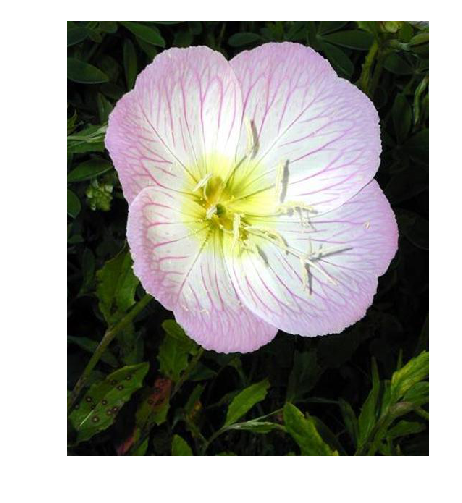

In [58]:
#PPloting the image
image_proc = Image.open('flowers/test/1/image_06743.jpg')
plt.axis('off')
plt.imshow(image_proc)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [59]:
def choose_test_image_path(data_test):
    """Chooses a random image from a given folder
    INPUT: data folder path string 
    """
    dir_class = random.choice(os.listdir(data_test))
    dir_file = random.choice(os.listdir(data_test + "/" + dir_class))
    image_path = f"{data_test}/{dir_class}/{dir_file}"
    print(f"Test file set to: {image_path}")
    return(image_path)

In [ ]:
#Choosing a random image for testing
data_test = 'flowers/test'
image_path = choose_test_image_path(data_test)
model = model_loaded
topk = 5

In [62]:
def predict(image_path, model, categories, topk, proc):
    """Predicts a class for an image based on a given model and categories names
    INPUT: 
    image source: string, model: nn model. categories dictionary, size of top classes to return, gpu switch
    OUTPUT:
    Returns probabilities, categories and related names, as an arrays of a topk 
    """
    if proc and torch.cuda.is_available():  
        cuda = torch.cuda.is_available()
        device = torch.device('cuda')
        print("Starting prediction session with cuda (gpu).")
        
    else:
        print("Starting prediction session with cpu (cuda unavailable).")
        device = torch.device('cpu')

    start = time.time()
    model.to(device)
    model.eval()
    
    image = process_image(image_path)
    image.unsqueeze_(0)
    

    image = image.to(device)    
    predict_ps = model(image)
    ps = torch.exp(predict_ps)
    top_ps, top_class = ps.topk(topk, dim = 1)      
    probs = top_ps.data.cpu().numpy()[0].tolist() 
    
    #inverting dictionary using dictionary comprehension 
    idx_to_classes_idx = {y:x for (x,y) in model.class_to_idx.items()}
    
    classes = []
    for idx in top_class.data.cpu().numpy()[0].tolist():
        classes.append(idx_to_classes_idx[idx])
    
    names = []
    for class_idx in classes:
        names.append(categories[class_idx])
    
    return probs, classes, names
    

In [63]:
#Predicting the image class
test_image_path = image_path
probs, classes, names = predict(test_image_path, model_loaded, cat_to_name, topk, proc)
print(probs)
print(classes)
print(names)

Starting prediction session with cuda (gpu).
[0.4932169020175934, 0.19369104504585266, 0.08051671832799911, 0.053875744342803955, 0.041306234896183014]
['5', '86', '83', '41', '1']
['english marigold', 'tree mallow', 'hibiscus', 'barbeton daisy', 'pink primrose']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [64]:
def sanity_check(test_image_path, model, categories, topk, proc):
    """Plots the composition of the test image and corresponding categories probabilities 
    INPUT:  
    test image path, nn model, categories dictionary, nr of top categories, gpu setting
    OUTPUT:
    Image and stats Pplot
    """
    probs, classes, names = predict(test_image_path, model, categories, topk, proc)
    
    flower_title = f"With a probability of {probs[0]:.4f}.. this is {names[0].title()}. Much wow XD"
    
    fig = plt.figure(figsize = (18,9))
   

    image = Image.open(test_image_path)
    ax1 = plt.subplot(1, 2, 1)
    ax1.axis('off')
    
    ax1.set_title(flower_title)
    ax1.imshow(image)
    
    
    y_ticks = np.arange(topk)
    ax2 = plt.subplot(1, 2, 2)
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(names)
    ax2.set_xlim(0, probs[0]+0.05)
    ax2.set_title('Category Probability')
    ax2.barh(y_ticks, probs, align = 'center')
    plt.gca().invert_yaxis()
    plt.show

Starting prediction session with cuda (gpu).


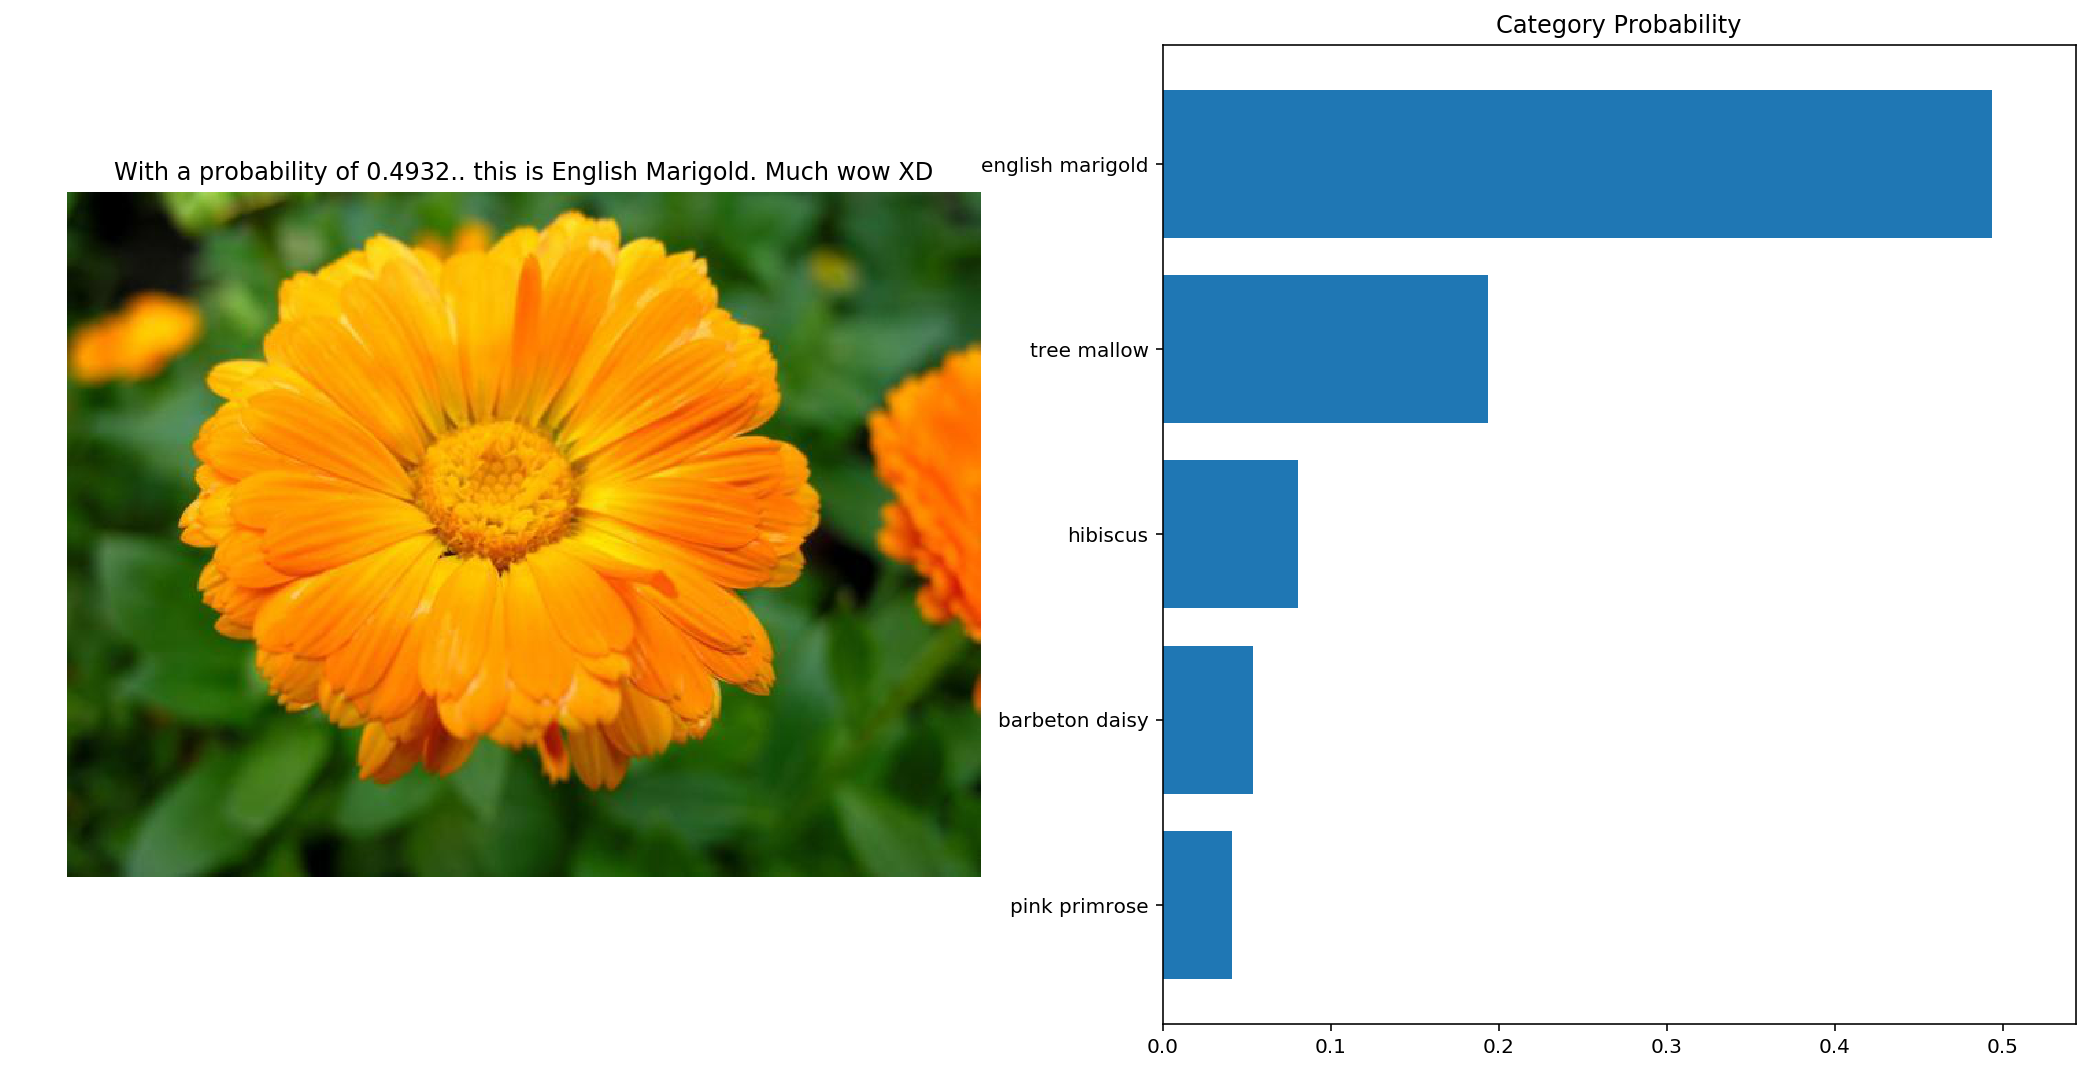

In [68]:
#Plot final composition
sanity_check(test_image_path, model_loaded, cat_to_name, topk, proc)

In [70]:
print('Awesome')

Awesome
